In [1]:
from operator import mod
import os
import math
from statistics import mode
import cv2
import urllib
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import datetime
import tensorflow as tf
from tensorflow import keras

import sys

sys.path.append(os.path.join(os.path.curdir, 'kitti-utils'))
from data_parser import KittiDataParser
from calibration import Calibration

KITTI_PATH = "/mnt/HDD/home/aditya/kitti/kitti_data/"
KITTI_EXAMPLE = os.path.join(KITTI_PATH, "2011_09_26/2011_09_26_drive_0001_sync/")
KITTI_CALIB_CAM2CAM = os.path.join(KITTI_PATH, "2011_09_26/calib_cam_to_cam.txt")
KITTI_CALIB_IMU2VEL = os.path.join(KITTI_PATH, "2011_09_26/calib_imu_to_velo.txt")
KITTI_CALIB_VEL2CAM = os.path.join(KITTI_PATH, "2011_09_26/calib_velo_to_cam.txt")

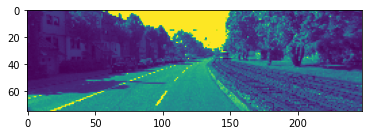

(75, 248)


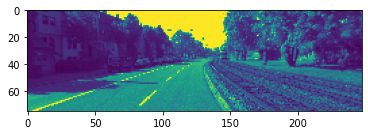

(75, 248)


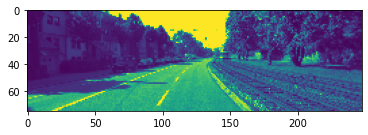

(75, 248)


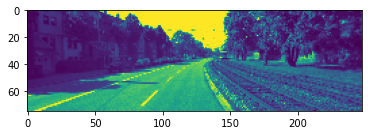

(75, 248)


In [2]:
kitti = KittiDataParser(KITTI_EXAMPLE, file_mode=1)
calib = Calibration(KITTI_CALIB_CAM2CAM)

img_arr = kitti.load_image("0000000000")

for i in range(len(img_arr)):
    img_arr[i] = cv2.resize(img_arr[i].copy(), (0, 0), fx = 0.2, fy = 0.2) 
    #img_arr[i] = cv2.cvtColor(img_arr[i].copy(), cv2.COLOR_BGR2RGB)
    img_arr[i] = cv2.cvtColor(img_arr[i].copy(), cv2.COLOR_BGR2GRAY)
    plt.imshow(img_arr[i])
    plt.show()
    print(img_arr[i].shape)

In [3]:
SIGMA = 200
NUM = 256
print("SIGMA=", SIGMA, "NUM=",NUM)
np.random.seed(0)
B = np.random.normal(0, SIGMA**0.5, size=NUM).reshape((NUM, 1))


# Explode the input vector v into [sin(B.v),  cos(B.v)] such that B is normal distribution N(0, SIGMA) with NUM elements
def explode(P, B=B):
    xi, yi, zi = P[0,0], P[1,0], P[2,0]
    v = np.array([xi, yi, zi]).reshape((3,1))
    mul = np.matmul(B, v.T)
        
    s = np.sin(mul).flatten()
    c = np.cos(mul).flatten()
    return np.concatenate((s,c))

# Dataset generation from the image
X, y = [], []
for img_i in range(len(img_arr)):
    cam_name = '0' + str(img_i)
    R = calib.calib['R_' + cam_name].reshape((3,3))
    T = calib.calib['T_' + cam_name].reshape((3,1))
    data = img_arr[img_i]
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            point = np.array([i, j, 0]).reshape((3,1))
            X.append( explode(np.matmul(R, point) + T) )
            y.append( data[i,j] / 256.0 )

X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3214567)

SIGMA= 200 NUM= 256


In [4]:
X.shape

(74400, 1536)

In [5]:
# Model Generation
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = X.shape[1], activation = 'ReLU', input_shape = (X.shape[1], )))
for i in range(0, int(math.ceil(math.log2(X.shape[1])))+1):
    units = max(3, X.shape[1] // 2**i)
    model.add(tf.keras.layers.Dense(units = units, activation = 'ReLU'))
    model.add(tf.keras.layers.Dense(units = units, activation = 'ReLU'))

model.compile(optimizer = 'adam', loss=keras.metrics.mean_squared_error, metrics = ['mse'])
model.summary()
"""
    keras.utils.plot_model( model, to_file='imgs/model_'+ str(SIGMA)) + "_" + str(NUM) + '.png', show_shapes=True, show_dtype=True,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
        layer_range=None, show_layer_activations=True
    )
"""

2022-02-06 11:04:29.930225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 11:04:29.936882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 11:04:29.937366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 11:04:29.938100: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1536)              2360832   
                                                                 
 dense_1 (Dense)             (None, 1536)              2360832   
                                                                 
 dense_2 (Dense)             (None, 1536)              2360832   
                                                                 
 dense_3 (Dense)             (None, 768)               1180416   
                                                                 
 dense_4 (Dense)             (None, 768)               590592    
                                                                 
 dense_5 (Dense)             (None, 384)               295296    
                                                                 
 dense_6 (Dense)             (None, 384)               1

'\n    keras.utils.plot_model( model, to_file=\'imgs/model_\'+ str(SIGMA)) + "_" + str(NUM) + \'.png\', show_shapes=True, show_dtype=True,\n        show_layer_names=True, rankdir=\'TB\', expand_nested=False, dpi=96,\n        layer_range=None, show_layer_activations=True\n    )\n'

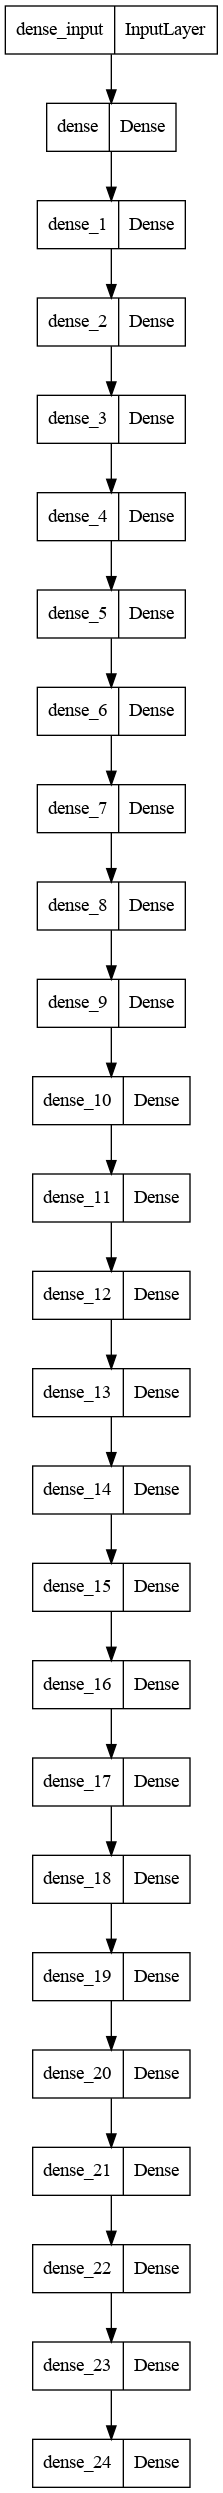

In [6]:
keras.utils.plot_model(model)

In [7]:
# Model Checkpoint Definition
MODEL_NAME = "model_" + str(SIGMA)+ "_" + str(NUM)
MODEL_SAVE_PATH = os.path.join('models',  MODEL_NAME)
CHECKPOINT_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'checkpoints')
MODEL_H5_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, MODEL_NAME + ".h5")
IMAGE_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'imgs')
B_SAVE_PATH = os.path.join(MODEL_SAVE_PATH, 'B.npy')
    
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_SAVE_PATH, exist_ok=True)
os.makedirs(IMAGE_SAVE_PATH, exist_ok=True)

np.save(B_SAVE_PATH, B)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_SAVE_PATH,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

class CustomCallback(keras.callbacks.Callback):
    def __init__(self) -> None:
        super().__init__()
        self.best_val_loss = float('inf')
    def on_epoch_end(self, epoch, logs=None):

        if logs['val_loss'] < self.best_val_loss:
            self.best_val_loss = logs['val_loss']
            self.model.save(MODEL_H5_SAVE_PATH, overwrite=True)

        if epoch%10==0:
            for img_i in range(len(img_arr)):
                cam_name = '0' + str(img_i)
                R = calib.calib['R_' + cam_name].reshape((3,3))
                T = calib.calib['T_' + cam_name].reshape((3,1))
                data = img_arr[img_i]
                    
                self.draw_img(self.model, data, R, T, cam_name)

    def draw_img(self, model, data, R, T, cam_name):
        xi = np.arange(0, data.shape[0])
        yi = np.arange(0, data.shape[1])
            
        res = np.zeros(data.shape, dtype=np.uint8)
        
        preds = np.transpose([np.tile(xi, len(yi)), np.repeat(yi, len(xi))])


        v = []
        for i in range(len(preds)):
            #tmpxi, tmpyi = np.round((preds[i][0]+1)*data.shape[0]/2.0), np.round((preds[i][1]+1)*data.shape[1]/2.0)
            tmpxi, tmpyi = np.round(preds[i][0]), np.round(preds[i][1])
            point = np.array([tmpxi, tmpyi, 0]).reshape((3,1))
            v.append( explode(np.matmul(R, point) + T) )
            #v.append(explode(tmpxi, tmpyi))
        v = np.array(v)
        mod_preds = model.predict(v)
        for i in range(len(preds)):
            px, py = np.round(preds[i][0]), np.round(preds[i][1])
            #px, py = int(np.round((preds[i][0]+1)*data.shape[0]/2.0)), int(np.round((preds[i][1]+1)*data.shape[1]/2.0))
            #r, g, b = list(map(lambda tmp: int(round(tmp)), mod_preds[i] * 256.0))
            #res[px,py] = r, g, b
            val = list(map(lambda tmp: int(round(tmp)), mod_preds[i] * 256.0))
            res[px,py] = val[0]

        IMG_PATH = os.path.join(IMAGE_SAVE_PATH, cam_name + "_" + str(datetime.datetime.now()) + '.png')
        #cv2.imwrite(IMG_PATH, res)
        #cv2.imwrite(IMG_PATH, cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
        #print('Saving', IMG_PATH)
        #cv2.imwrite(IMG_PATH, cv2.cvtColor(res.copy(), cv2.COLOR_BGR2RGB))
        
        plt.imshow(res)
        plt.show()

2022-02-06 11:15:57.477313: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 457113600 exceeds 10% of free system memory.


Epoch 1/25
2320/2325 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011

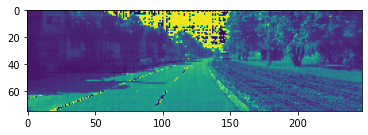

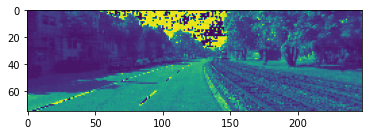

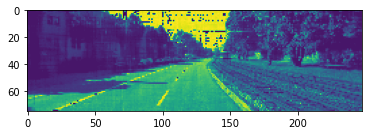

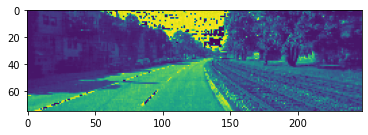

2325/2325 [==============================] - 25s 11ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 7.2670e-04 - val_mse: 7.2670e-04
Epoch 2/25
2323/2325 [============================>.] - ETA: 0s - loss: 0.0010 - mse: 0.0010

INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


2325/2325 [==============================] - 19s 8ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 6.1446e-04 - val_mse: 6.1446e-04
Epoch 3/25
2325/2325 [==============================] - 15s 7ms/step - loss: 8.9844e-04 - mse: 8.9844e-04 - val_loss: 8.6080e-04 - val_mse: 8.6080e-04
Epoch 4/25
2325/2325 [==============================] - 15s 7ms/step - loss: 7.7701e-04 - mse: 7.7701e-04 - val_loss: 6.3090e-04 - val_mse: 6.3090e-04
Epoch 5/25
2322/2325 [============================>.] - ETA: 0s - loss: 8.9486e-04 - mse: 8.9486e-04

INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


2325/2325 [==============================] - 19s 8ms/step - loss: 8.9430e-04 - mse: 8.9430e-04 - val_loss: 5.7633e-04 - val_mse: 5.7633e-04
Epoch 6/25
2323/2325 [============================>.] - ETA: 0s - loss: 6.1767e-04 - mse: 6.1767e-04

INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


2325/2325 [==============================] - 19s 8ms/step - loss: 6.1762e-04 - mse: 6.1762e-04 - val_loss: 5.0823e-04 - val_mse: 5.0823e-04
Epoch 7/25
2325/2325 [==============================] - 16s 7ms/step - loss: 7.3959e-04 - mse: 7.3959e-04 - val_loss: 7.5482e-04 - val_mse: 7.5482e-04
Epoch 8/25
2325/2325 [==============================] - 16s 7ms/step - loss: 7.9812e-04 - mse: 7.9812e-04 - val_loss: 6.4200e-04 - val_mse: 6.4200e-04
Epoch 9/25
2325/2325 [==============================] - 16s 7ms/step - loss: 6.2776e-04 - mse: 6.2776e-04 - val_loss: 6.3358e-04 - val_mse: 6.3358e-04
Epoch 10/25
2325/2325 [==============================] - 16s 7ms/step - loss: 6.3421e-04 - mse: 6.3421e-04 - val_loss: 6.8086e-04 - val_mse: 6.8086e-04
Epoch 11/25
2323/2325 [============================>.] - ETA: 0s - loss: 7.7200e-04 - mse: 7.7200e-04

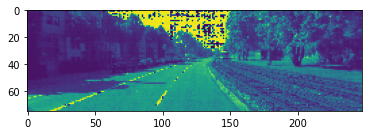

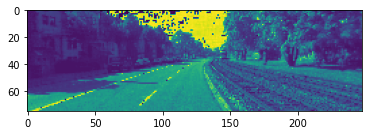

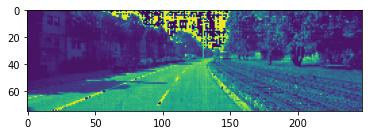

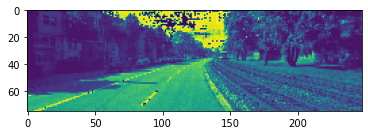

2325/2325 [==============================] - 24s 11ms/step - loss: 7.7174e-04 - mse: 7.7174e-04 - val_loss: 7.5457e-04 - val_mse: 7.5457e-04
Epoch 12/25
2325/2325 [==============================] - 16s 7ms/step - loss: 7.7794e-04 - mse: 7.7794e-04 - val_loss: 9.5409e-04 - val_mse: 9.5409e-04
Epoch 13/25
2325/2325 [==============================] - ETA: 0s - loss: 5.7715e-04 - mse: 5.7715e-04

INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


2325/2325 [==============================] - 19s 8ms/step - loss: 5.7715e-04 - mse: 5.7715e-04 - val_loss: 3.7253e-04 - val_mse: 3.7253e-04
Epoch 14/25
2325/2325 [==============================] - 16s 7ms/step - loss: 3.9381e-04 - mse: 3.9381e-04 - val_loss: 4.0357e-04 - val_mse: 4.0357e-04
Epoch 15/25
2325/2325 [==============================] - 16s 7ms/step - loss: 6.3344e-04 - mse: 6.3344e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 16/25
2325/2325 [==============================] - 16s 7ms/step - loss: 6.3347e-04 - mse: 6.3347e-04 - val_loss: 3.8409e-04 - val_mse: 3.8409e-04
Epoch 17/25
2325/2325 [==============================] - 15s 7ms/step - loss: 4.4907e-04 - mse: 4.4907e-04 - val_loss: 5.1105e-04 - val_mse: 5.1105e-04
Epoch 18/25
2325/2325 [==============================] - 15s 7ms/step - loss: 5.6334e-04 - mse: 5.6334e-04 - val_loss: 5.8592e-04 - val_mse: 5.8592e-04
Epoch 19/25
2325/2325 [==============================] - 16s 7ms/step - loss: 5.5328e-04 - mse: 5.5328e-04 -

INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


INFO:tensorflow:Assets written to: models/model_200_256/checkpoints/assets


2325/2325 [==============================] - 19s 8ms/step - loss: 4.7962e-04 - mse: 4.7962e-04 - val_loss: 2.1930e-04 - val_mse: 2.1930e-04
Epoch 21/25
2316/2325 [============================>.] - ETA: 0s - loss: 3.4057e-04 - mse: 3.4057e-04

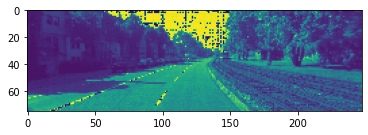

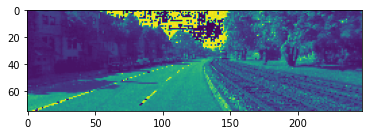

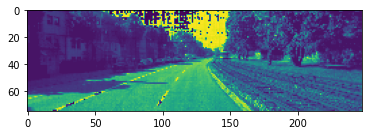

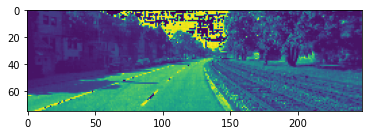

2325/2325 [==============================] - 24s 10ms/step - loss: 3.4043e-04 - mse: 3.4043e-04 - val_loss: 3.9352e-04 - val_mse: 3.9352e-04
Epoch 22/25
2325/2325 [==============================] - 17s 7ms/step - loss: 4.7556e-04 - mse: 4.7556e-04 - val_loss: 3.6485e-04 - val_mse: 3.6485e-04
Epoch 23/25
2325/2325 [==============================] - 18s 8ms/step - loss: 3.5556e-04 - mse: 3.5556e-04 - val_loss: 4.0038e-04 - val_mse: 4.0038e-04
Epoch 24/25
2325/2325 [==============================] - 17s 7ms/step - loss: 4.7405e-04 - mse: 4.7405e-04 - val_loss: 4.8649e-04 - val_mse: 4.8649e-04
Epoch 25/25
2325/2325 [==============================] - 16s 7ms/step - loss: 4.0260e-04 - mse: 4.0260e-04 - val_loss: 3.6521e-04 - val_mse: 3.6521e-04


In [15]:
# Model Training
#model.fit(X, y, epochs=55, validation_data=(X_test, y_test), callbacks=[CustomCallback(), model_checkpoint_callback])
model.fit(X, y, epochs=25, validation_data=(X, y), callbacks=[CustomCallback(), model_checkpoint_callback])

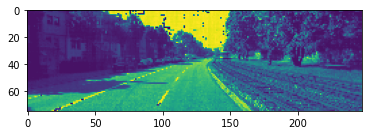

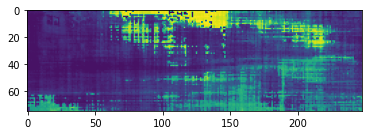

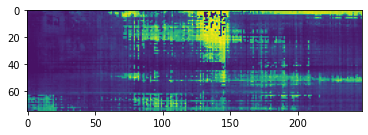

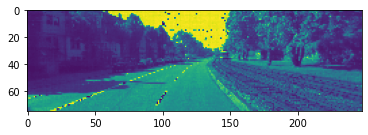

In [17]:
def draw_img(model, data_shape, R, T):
    xi = np.arange(0, data_shape[0])
    yi = np.arange(0, data_shape[1])
            
    res = np.zeros(data.shape, dtype=np.uint8)
        
    preds = np.transpose([np.tile(xi, len(yi)), np.repeat(yi, len(xi))])


    v = []
    for i in range(len(preds)):
        #tmpxi, tmpyi = np.round((preds[i][0]+1)*data.shape[0]/2.0), np.round((preds[i][1]+1)*data.shape[1]/2.0)
        tmpxi, tmpyi = np.round(preds[i][0]), np.round(preds[i][1])
        point = np.array([tmpxi, tmpyi, 0]).reshape((3,1))
        v.append( explode(np.matmul(R, point) + T) )
        #v.append(explode(tmpxi, tmpyi))
    v = np.array(v)
    mod_preds = model.predict(v)
    for i in range(len(preds)):
        px, py = np.round(preds[i][0]), np.round(preds[i][1])
        val = list(map(lambda tmp: int(round(tmp)), mod_preds[i] * 256.0))
        res[px,py] = val[0]
    
    plt.imshow(res)
    plt.show()
    
def pivot(R0, T0, R3, T3, steps=100):
    for i in range(steps+1):
        R = (i*R0 + (steps-i)*R3) / steps
        T = (i*T0 + (steps-i)*T3) / steps

        draw_img(model, img_arr[0].shape, R, T)
    
R0 = calib.calib['R_00'].reshape((3,3))
T0 = calib.calib['T_00'].reshape((3,1))
#R3 = calib.calib['R_03'].reshape((3,3))
#T3 = calib.calib['T_03'].reshape((3,1))
R3 = calib.calib['R_02'].reshape((3,3))
T3 = calib.calib['T_02'].reshape((3,1))

pivot(R0, T0, R3, T3, 3)

In [14]:
"""
Sensor Calibration
==================

The sensor calibration zip archive contains files, storing matrices in
row-aligned order, meaning that the first values correspond to the first
row:

calib_cam_to_cam.txt: Camera-to-camera calibration
--------------------------------------------------

  - S_xx: 1x2 size of image xx before rectification
  - K_xx: 3x3 calibration matrix of camera xx before rectification
  - D_xx: 1x5 distortion vector of camera xx before rectification
  - R_xx: 3x3 rotation matrix of camera xx (extrinsic)
  - T_xx: 3x1 translation vector of camera xx (extrinsic)
  - S_rect_xx: 1x2 size of image xx after rectification
  - R_rect_xx: 3x3 rectifying rotation to make image planes co-planar
  - P_rect_xx: 3x4 projection matrix after rectification

Note: When using this dataset you will most likely need to access only
P_rect_xx, as this matrix is valid for the rectified image sequences.

calib_velo_to_cam.txt: Velodyne-to-camera registration
------------------------------------------------------

  - R: 3x3 rotation matrix
  - T: 3x1 translation vector
  - delta_f: deprecated
  - delta_c: deprecated

R|T takes a point in Velodyne coordinates and transforms it into the
coordinate system of the left video camera. Likewise it serves as a
representation of the Velodyne coordinate frame in camera coordinates.

calib_imu_to_velo.txt: GPS/IMU-to-Velodyne registration
-------------------------------------------------------

  - R: 3x3 rotation matrix
  - T: 3x1 translation vector

R|T takes a point in GPS/IMU coordinates and transforms it into the
coordinate system of the Velodyne scanner. Likewise it serves as a
representation of the GPS/IMU coordinate frame in Velodyne coordinates.
"""

'\nSensor Calibration\n==================\n\nThe sensor calibration zip archive contains files, storing matrices in\nrow-aligned order, meaning that the first values correspond to the first\nrow:\n\ncalib_cam_to_cam.txt: Camera-to-camera calibration\n--------------------------------------------------\n\n  - S_xx: 1x2 size of image xx before rectification\n  - K_xx: 3x3 calibration matrix of camera xx before rectification\n  - D_xx: 1x5 distortion vector of camera xx before rectification\n  - R_xx: 3x3 rotation matrix of camera xx (extrinsic)\n  - T_xx: 3x1 translation vector of camera xx (extrinsic)\n  - S_rect_xx: 1x2 size of image xx after rectification\n  - R_rect_xx: 3x3 rectifying rotation to make image planes co-planar\n  - P_rect_xx: 3x4 projection matrix after rectification\n\nNote: When using this dataset you will most likely need to access only\nP_rect_xx, as this matrix is valid for the rectified image sequences.\n\ncalib_velo_to_cam.txt: Velodyne-to-camera registration\n---

In [11]:
calib.calib

{'corner_dist': array([0.0995]),
 'S_00': array([1392.,  512.]),
 'K_00': array([984.2439,   0.    , 690.    ,   0.    , 980.8141, 233.1966,
          0.    ,   0.    ,   1.    ]),
 'D_00': array([-0.3728755 ,  0.2037299 ,  0.00221903,  0.00138371, -0.07233722]),
 'R_00': array([1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'T_00': array([ 2.573699e-16, -1.059758e-16,  1.614870e-16]),
 'S_rect_00': array([1242.,  375.]),
 'R_rect_00': array([ 0.9999239 ,  0.00983776, -0.00744505, -0.0098698 ,  0.9999421 ,
        -0.00427846,  0.00740253,  0.00435161,  0.9999631 ]),
 'P_rect_00': array([721.5377,   0.    , 609.5593,   0.    ,   0.    , 721.5377,
        172.854 ,   0.    ,   0.    ,   0.    ,   1.    ,   0.    ]),
 'S_01': array([1392.,  512.]),
 'K_01': array([989.5267,   0.    , 702.    ,   0.    , 987.8386, 245.559 ,
          0.    ,   0.    ,   1.    ]),
 'D_01': array([-0.3644661 ,  0.1790019 ,  0.00114811, -0.00062986, -0.05314062]),
 'R_01': array([ 0.9993513 ,  0.01860866, -0.0308348